In [1]:
%matplotlib inline
import pandas as pd
from scipy.integrate import cumtrapz
import numpy as np
import matplotlib.pyplot as plt
import RecreateBiryukov

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308 entries, 1 to 2524
Data columns (total 18 columns):
NAME          308 non-null object
F0            308 non-null float64
F0_err        308 non-null float64
F1            308 non-null float64
F1_err        308 non-null float64
F2            308 non-null float64
F2_err        308 non-null float64
P0            308 non-null float64
P0_err        308 non-null float64
P1            308 non-null float64
P1_err        308 non-null float64
BINARY        0 non-null object
TYPE          54 non-null object
AGE           308 non-null float64
F2_rel_err    308 non-null float64
nobs          308 non-null float64
tch           308 non-null float64
tch_years     308 non-null float64
dtypes: float64(15), object(3)
memory usage: 45.7+ KB
None


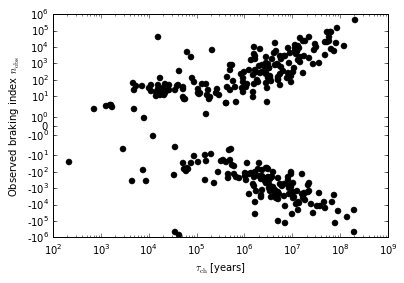

In [4]:
df = RecreateBiryukov.GetData()
tch = df['tch'].values
nobs = df['nobs'].values
RecreateBiryukov.NobsPlot(df)
plt.show()

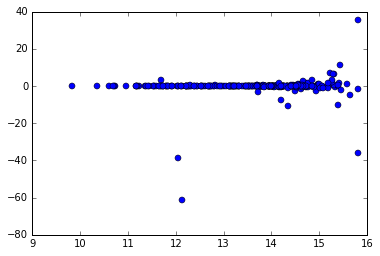

In [74]:
nobs_scaled = nobs/np.mean(np.abs(nobs))
tch_scaled = np.log10(tch)
plt.plot(tch_scaled, nobs_scaled, "o")
plt.show()

In [75]:
import pymc3 as pm
N = len(tch)
with pm.Model() as hierarchical_model:
    # hyperparameters
    psi0 = pm.Uniform('psi0', lower=0, upper=2*np.pi, shape=N)
    A = pm.Normal("A", mu=0, sd=100**2)
    f = pm.Normal('f', mu=3, sd=100**2)
    eps = pm.Uniform('eps', lower=0, upper=10)
    
    mu = tch * (A/f) * pm.sin(2*np.pi*f*tch_scaled + psi0)
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=eps, observed=nobs_scaled)
    
nsamples = 30000
nburn = 10000
with hierarchical_model:
    step = pm.Metropolis()
    hierarchical_trace = pm.sample(nsamples, step, progressbar=True)

 [-----------------100%-----------------] 30000 of 30000 complete in 36.3 sec

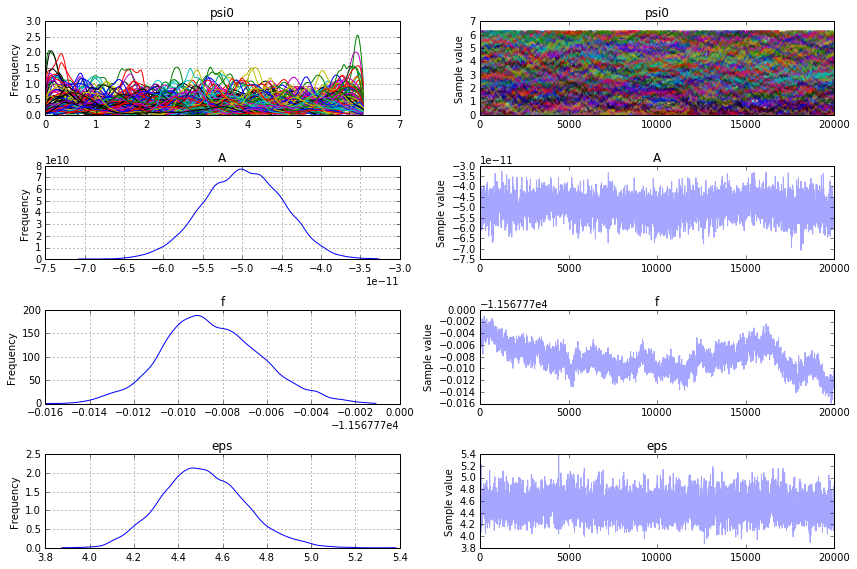

In [76]:
pm.traceplot(hierarchical_trace[nburn:])
plt.show()

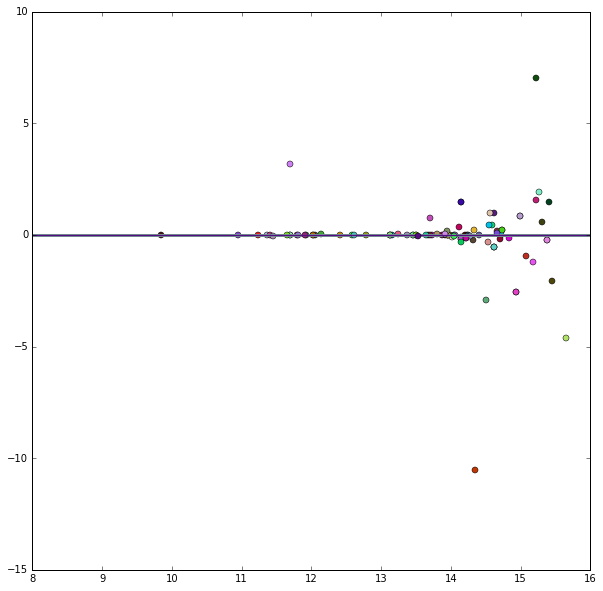

In [84]:
npp = 100
repeats = 1
fig, ax = plt.subplots(figsize=(10, 10))
xfit = np.linspace(8, 16, 1000)

for i  in np.random.randint(0, N, npp):
    color = np.random.uniform(0, 1, 3)
    for j in range(repeats):
        s = hierarchical_trace[np.random.randint(nburn, nsamples)]
        #yfit = s['A'] * xfit * np.sin(2*np.pi*s['f']*xfit + s['psi0'][i])
        yfitmax = s['A'] * xfit
        ax.plot(xfit, yfitmax, "-", lw=1.1, color=color)
        ax.plot(xfit, -yfitmax, "-", lw=1.1, color=color)
    ax.plot(tch_scaled[i], nobs_scaled[i], "o", color=color)

#ax.set_yscale("symlog")
plt.show()